In [1]:
import os
import re
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms,datasets
import torch.utils.data

In [2]:
import torch.autograd
from torch.autograd import Variable
import math
import torch.distributions as dist

In [3]:
torch.__version__

'1.0.0'

In [4]:
torch.manual_seed(42)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
batchsize = 100

In [23]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batchsize, shuffle=True)

In [24]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),batch_size=batchsize, shuffle=True)

In [11]:
inp = 784
layer1 = 128
layer2 = 64
out = 10

In [12]:
class model1(nn.Module):
    def __init__(self):
        super(model1,self).__init__()
        self.fc1 = nn.Linear(inp,layer1)
        self.fc2 = nn.Linear(layer1,layer2)
        self.fc3 = nn.Linear(layer2,out)
        self.drop = nn.Dropout(0.2)
        self.relu = nn.ReLU()
    def forward(self,x):
        out = self.drop(self.relu(self.fc1(x)))
        out = self.drop(self.relu(self.fc2(out)))
        return F.log_softmax(self.fc3(out),dim=1)

In [13]:
model_relu = model1().to(device)

In [14]:
optimizer = optim.Adam(model_relu.parameters())

In [17]:
def calculate_accuracy(net,loader):
    with torch.no_grad():
        net.eval()
        correct = 0
        total = 0
        for i,(Xtrain,ytrain) in enumerate(loader):
            Xtrain = Xtrain.to(device).view(Xtrain.size(0),-1)
            ytrain = ytrain.to(device)
            
            output = net(Xtrain)
            
            _,predictions = torch.max(output,1)
            correct+=torch.sum(predictions==ytrain).item()
            total+=Xtrain.size(0)
        
        return ((correct/total)*100)

In [18]:
numepochs = 10

In [19]:
model_relu.train()
trainloss_relu = []
testacc_relu = []
for epoch in range(numepochs):
    for i,(data,labels) in enumerate(train_loader):
        data = data.to(device).view(data.size(0),-1)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model_relu(data)
        loss = F.nll_loss(output,labels)
        
        loss.backward()
        optimizer.step()
        
        trainloss_relu.append(loss)
        
    train_acc = calculate_accuracy(model_relu,train_loader)
    test_acc = calculate_accuracy(model_relu,test_loader)
    testacc_relu.append(test_acc)
    
    print("Epoch {} Train Accuracy {} Test Accuracy {}".format(epoch,train_acc,test_acc))

Epoch 0 Train Accuracy 97.00999999999999 Test Accuracy 96.61999999999999
Epoch 1 Train Accuracy 97.98 Test Accuracy 97.14
Epoch 2 Train Accuracy 98.295 Test Accuracy 97.34
Epoch 3 Train Accuracy 98.98666666666666 Test Accuracy 97.89999999999999
Epoch 4 Train Accuracy 99.14166666666667 Test Accuracy 97.7
Epoch 5 Train Accuracy 99.15666666666667 Test Accuracy 97.83
Epoch 6 Train Accuracy 99.26666666666667 Test Accuracy 97.89
Epoch 7 Train Accuracy 99.35333333333334 Test Accuracy 97.67
Epoch 8 Train Accuracy 99.37833333333333 Test Accuracy 97.77
Epoch 9 Train Accuracy 99.33833333333332 Test Accuracy 97.63


In [28]:
class model2(nn.Module):
    def __init__(self):
        super(model2,self).__init__()
        self.drop = nn.AlphaDropout(0.2)
        self.selu = nn.SELU()
        self.fc1 = nn.Linear(inp,layer1)
        self.fc2 = nn.Linear(layer1,layer2)
        self.fc3 = nn.Linear(layer2,out)
    def init_weights(self):
        torch.nn.init.normal_(self.fc1.weight.data, mean=0, std=math.sqrt(1/inp))
        torch.nn.init.normal_(self.fc1.bias.data, mean=0, std=0)
        torch.nn.init.normal_(self.fc2.weight.data, mean=0, std=math.sqrt(1/layer1))
        torch.nn.init.normal_(self.fc2.bias.data, mean=0, std=0)
        torch.nn.init.normal_(self.fc3.weight.data, mean=0, std=math.sqrt(1/layer2))
        torch.nn.init.normal_(self.fc3.bias.data, mean=0)
    def forward(self,x):
        out = self.drop(self.selu(self.fc1(x)))
        out = self.drop(self.selu(self.fc2(out)))
        out = F.log_softmax(self.fc3(out),dim=1)
        return out

In [29]:
model_selu = model2().to(device)

In [30]:
model_selu.init_weights()

In [31]:
optimizer = optim.Adam(model_selu.parameters())

In [32]:
model_selu.train()
trainloss_selu = []
testacc_selu = []
for epoch in range(numepochs):
    for i,(data,labels) in enumerate(train_loader):
        data = data.to(device).view(data.size(0),-1)
        labels = labels.to(device)
        model_selu.zero_grad()
        output = model_selu(data)
        loss = F.nll_loss(output,labels)
        
        loss.backward()
        optimizer.step()
        
        trainloss_selu.append(loss)
        
        
    train_acc = calculate_accuracy(model_selu,train_loader)
    test_acc = calculate_accuracy(model_selu,test_loader)
    testacc_selu.append(test_acc)
    
    print("Epoch {} Train Accuracy {} Test Accuracy {}".format(epoch,train_acc,test_acc))

Epoch 0 Train Accuracy 94.73 Test Accuracy 94.53
Epoch 1 Train Accuracy 97.63333333333334 Test Accuracy 96.69
Epoch 2 Train Accuracy 98.40833333333333 Test Accuracy 97.35000000000001
Epoch 3 Train Accuracy 98.595 Test Accuracy 97.37
Epoch 4 Train Accuracy 98.97666666666667 Test Accuracy 97.50999999999999
Epoch 5 Train Accuracy 98.81833333333333 Test Accuracy 97.41
Epoch 6 Train Accuracy 99.18833333333333 Test Accuracy 97.61
Epoch 7 Train Accuracy 99.35166666666667 Test Accuracy 97.61999999999999
Epoch 8 Train Accuracy 99.55166666666668 Test Accuracy 97.78
Epoch 9 Train Accuracy 99.65666666666667 Test Accuracy 97.97


In [33]:
import matplotlib.pyplot as plt

In [34]:
iterations = range(numepochs)

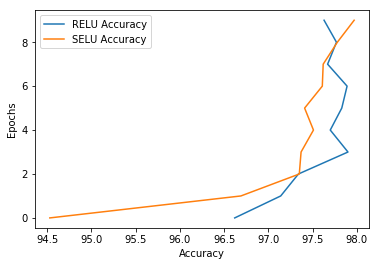

In [35]:
plt.plot(testacc_relu,iterations,label='RELU Accuracy')
plt.plot(testacc_selu,iterations,label='SELU Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend()
plt.show()

In [36]:
batches = range(len(trainloss_relu))

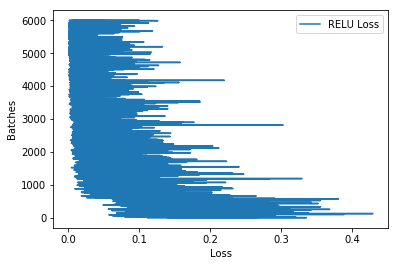

In [37]:
plt.plot(trainloss_relu,batches,label='RELU Loss')
plt.xlabel('Loss')
plt.ylabel('Batches')
plt.legend()
plt.show()

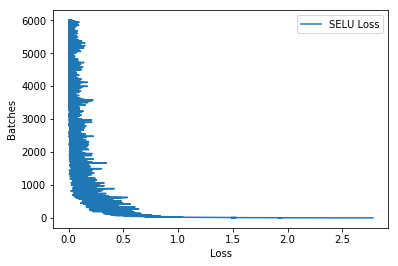

In [38]:
plt.plot(trainloss_selu,batches,label='SELU Loss')
plt.xlabel('Loss')
plt.ylabel('Batches')
plt.legend()
plt.show()